## torchinfo

In [3]:
import torch
import timm

model = timm.create_model('densenet121', pretrained=False, num_classes=10)
model.load_state_dict(torch.load('models/densenet121_out10.pt'))
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
  

In [4]:
# use torchinfo.summary
from torchinfo import summary

summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [1, 10]                   --
├─Sequential: 1-1                             [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNormAct2d: 2-2                    [1, 64, 112, 112]         128
│    │    └─Identity: 3-1                     [1, 64, 112, 112]         --
│    │    └─ReLU: 3-2                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-3                         [1, 64, 56, 56]           --
│    └─DenseBlock: 2-4                        [1, 256, 56, 56]          --
│    │    └─DenseLayer: 3-3                   [1, 32, 56, 56]           45,440
│    │    └─DenseLayer: 3-4                   [1, 32, 56, 56]           49,600
│    │    └─DenseLayer: 3-5                   [1, 32, 56, 56]           53,760
│    │    └─DenseLayer: 3-6                   [1, 32, 56, 56]           57,920


## grad-cam

d:\Anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\vgg11-8a719046.pth
100%|██████████| 507M/507M [08:36<00:00, 1.03MB/s] 


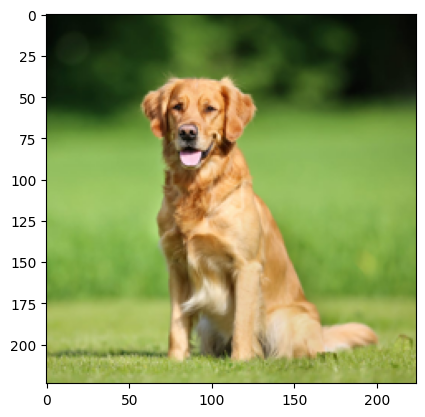

In [4]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

model = models.vgg11(pretrained=True)
img_path = 'images/dog.jpg'
# resize操作是为了和传入神经网络训练图片大小一致
img = Image.open(img_path).resize((224,224))
# 需要将原始图片转为np.float32格式并且在0-1之间 
rgb_img = np.float32(img)/255
plt.imshow(img)

In [15]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

<class 'numpy.ndarray'>


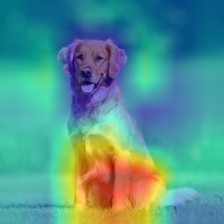

In [14]:
from pytorch_grad_cam import GradCAM,ScoreCAM,GradCAMPlusPlus,AblationCAM,XGradCAM,EigenCAM,FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 将图片转为tensor
img_tensor = torch.from_numpy(rgb_img).permute(2,0,1).unsqueeze(0)  # HWC -> CHW
pred = model(img_tensor)
pred = int(pred.argmax(dim=1).item())
target_layers = [model.features[-1]]
# 选取合适的类激活图，但是ScoreCAM和AblationCAM需要batch_size
cam = GradCAM(model=model,target_layers=target_layers)
targets = [ClassifierOutputTarget(pred)]   # 上方preds需要设定，比如ImageNet有1000类，这里可以设为200
grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
print(type(cam_img))
Image.fromarray(cam_img)